In [129]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
from PyDSTool import *
import scipy.optimize as sco
from scipy import optimize
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate

## Parameters and Initial Conditions

In [130]:
print(nelsonACTH[0,1], nelsonCortisol[0,1])

20.71677102294828 6.314796551724138


In [3]:
# set initial conditions, with order CRH, ACTH, Cortisol
y0 = [1, 20.71677102294828, 6.314796551724138]

In [39]:
# initialize parameter values for running without optimization
eta = 0.5
K_d = 6
k_1 = 0.023
k_2 = 0.041
k_3 = 0.009
sigma = 1
k_C0 = 0
tau = 0
S_e = 0
t_spike = 30

# parameters that aren't to be optimized
# I will need to recompute these each time parameters are 
# generated by the optimization algorithm, because they depend 
# on those params
S = S_e - sigma
k_C = k_C0*np.exp(S - sigma)

In [40]:
# define bounds on parameters to be optimized, order matches the 
# definition of params variable in model function

bounds = [(0,1), (4,10), (0.013, 0.033), (0.001, 0.051), (0.0009, 0.019), (0, 10), (0.0001, 1), (0,10), (0,10), (20,40)]

In [6]:
# length of time over which we wish to integrate, not honestly sure if this definition is still necessary
timeLength = (-0.01,140.01)

# time interval and step definition, for using scipy.integrate.ode
t_start = -0.01
t_end = 140.01
t_step = 0.01

## Put Raw Data Into Arrays

In [7]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [8]:
# actually, I think this model is scaled in minutes, so this block is unnecessary

# convert time scales to hours for the raw data, because the model is in terms of hours
#for i in range(len(yehudaControlCortisol)):
#    yehudaControlCortisol[i,0] = yehudaControlCortisol[i,0]/60
#    yehudaPTSDCortisol[i,0] = yehudaPTSDCortisol[i,0]/60
#    yehudaDepressedCortisol[i,0] = yehudaDepressedCortisol[i,0]/60

In [9]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [10]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [11]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [12]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [13]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [14]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

In [15]:
# data from Dr Erik Nelson
nelsonACTH_data = np.genfromtxt("tsst_acth_nelson.txt")
nelsonCortisol_data = np.genfromtxt("tsst_cort_nelson.txt")

### Smooth Data, If Desired

In [16]:
# this function computes the moving average over the neighboring 5 points
def smoothing(a, n=5) :
    idx = int((n-1)/2)
    ret = np.cumsum(a, dtype=float)
    ret[idx+1:-idx] = ret[n:] - ret[:-n]
    ret[idx] = ret[idx+2]
    return ret[idx:-idx]/n

In [17]:
yehudaControlCortisol_smooth = yehudaControlCortisol
yehudaPTSDCortisol_smooth = yehudaPTSDCortisol
yehudaDepressedCortisol_smooth = yehudaDepressedCortisol

yehudaControlCortisol_smooth[2:-2,1] = smoothing(yehudaControlCortisol[:,1])
yehudaPTSDCortisol_smooth[2:-2,1] = smoothing(yehudaPTSDCortisol[:,1])
yehudaDepressedCortisol_smooth[2:-2,1] = smoothing(yehudaDepressedCortisol[:,1])

In [18]:
# run smoothing if so desired
# REMEMBER: need to re-extract the data from the files into the non-smooth arrays to make them non-smooth.
#     I'm still not sure why it's smoothing the original data when I only save the values from the smoothing function
#     into the smooth arrays
carrollControlCortisol_smooth = carrollControlCortisol
carrollHCDepressedCortisol_smooth = carrollHCDepressedCortisol
carrollLCDepressedCortisol_smooth = carrollLCDepressedCortisol

carrollControlACTH_smooth = carrollControlACTH
carrollHCDepressedACTH_smooth = carrollHCDepressedACTH
carrollLCDepressedACTH_smooth = carrollLCDepressedACTH

carrollControlCortisol_rearr_smooth = carrollControlCortisol_rearr
carrollHCDepressedCortisol_rearr_smooth = carrollHCDepressedCortisol_rearr
carrollLCDepressedCortisol_rearr_smooth = carrollLCDepressedCortisol_rearr

carrollControlACTH_rearr_smooth = carrollControlACTH_rearr
carrollHCDepressedACTH_rearr_smooth = carrollHCDepressedACTH_rearr
carrollLCDepressedACTH_rearr_smooth = carrollLCDepressedACTH_rearr

carrollControlCortisol_smooth[2:-2,1] = smoothing(carrollControlCortisol[:,1])
carrollHCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol[:,1])
carrollLCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol[:,1])

carrollControlACTH_smooth[2:-2,1] = smoothing(carrollControlACTH[:,1])
carrollHCDepressedACTH_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH[:,1])
carrollLCDepressedACTH_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH[:,1])

carrollControlCortisol_rearr_smooth[2:-2,1] = smoothing(carrollControlCortisol_rearr[:,1])
carrollHCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol_rearr[:,1])
carrollLCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol_rearr[:,1])

carrollControlACTH_rearr_smooth[2:-2,1] = smoothing(carrollControlACTH_rearr[:,1])
carrollHCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH_rearr[:,1])
carrollLCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH_rearr[:,1])

In [19]:
golierPTSDCortisol_smooth = golierPTSDCortisol
golierNonPTSDTraumaExposedCortisol_smooth = golierNonPTSDTraumaExposedCortisol
golierNonPTSDNonExposedCortisol_smooth = golierNonPTSDNonExposedCortisol
golierPTSDACTH_smooth = golierPTSDACTH
golierNonPTSDTraumaExposedACTH_smooth = golierNonPTSDTraumaExposedACTH
golierNonPTSDNonExposedACTH_smooth = golierNonPTSDNonExposedACTH

golierPTSDCortisol_smooth[2:-2,1] = smoothing(golierPTSDCortisol[:,1])
golierNonPTSDTraumaExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol[:,1])
golierNonPTSDNonExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol[:,1])

golierPTSDACTH_smooth[2:-2,1] = smoothing(golierPTSDACTH[:,1])
golierNonPTSDTraumaExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH[:,1])
golierNonPTSDNonExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH[:,1])

In [20]:
golierPTSDCortisol_rearr_smooth = golierPTSDCortisol_rearr
golierNonPTSDTraumaExposedCortisol_rearr_smooth = golierNonPTSDTraumaExposedCortisol_rearr
golierNonPTSDNonExposedCortisol_rearr_smooth = golierNonPTSDNonExposedCortisol_rearr
golierPTSDACTH_rearr_smooth = golierPTSDACTH_rearr
golierNonPTSDTraumaExposedACTH_rearr_smooth = golierNonPTSDTraumaExposedACTH_rearr
golierNonPTSDNonExposedACTH_rearr_smooth = golierNonPTSDNonExposedACTH_rearr

golierPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(golierPTSDCortisol_rearr[:,1])
golierNonPTSDTraumaExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol_rearr[:,1])
golierNonPTSDNonExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol_rearr[:,1])

golierPTSDACTH_rearr_smooth[2:-2,1] = smoothing(golierPTSDACTH_rearr[:,1])
golierNonPTSDTraumaExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH_rearr[:,1])
golierNonPTSDNonExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH_rearr[:,1])

In [21]:
bremnerAbusedPTSDCortisol_rearr_smooth = bremnerAbusedPTSDCortisol_rearr
bremnerNonAbusedPTSDCortisol_rearr_smooth = bremnerNonAbusedPTSDCortisol_rearr
bremnerNonAbusedNonPTSDCortisol_rearr_smooth = bremnerNonAbusedNonPTSDCortisol_rearr

bremnerAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedNonPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol_rearr[:,1])

In [22]:
bremnerAbusedPTSDCortisol_smooth = bremnerAbusedPTSDCortisol
bremnerNonAbusedPTSDCortisol_smooth = bremnerNonAbusedPTSDCortisol
bremnerNonAbusedNonPTSDCortisol_smooth = bremnerNonAbusedNonPTSDCortisol

bremnerAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol[:,1])
bremnerNonAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol[:,1])
bremnerNonAbusedNonPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol[:,1])

### Re-run Code to Input Non-Smoothed Data into Array

In [23]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [24]:
# actually, I think this model is scaled in minutes, so this block is unnecessary

# convert time scales to hours for the raw data, because the model is in terms of hours
#for i in range(len(yehudaControlCortisol)):
#    yehudaControlCortisol[i,0] = yehudaControlCortisol[i,0]/60
#    yehudaPTSDCortisol[i,0] = yehudaPTSDCortisol[i,0]/60
#    yehudaDepressedCortisol[i,0] = yehudaDepressedCortisol[i,0]/60

In [25]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [26]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [27]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [28]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [29]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [30]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

### Plot Data Sets

In [31]:
# make time scale in hours for graphing
j = 0
k = 0
l = 0

timeCarroll = np.zeros(len(carrollControlCortisol[:,0]))
for i in carrollControlCortisol[:,0]:
    timeCarroll[l] = i/60
    l += 1

In [32]:
for i in range(len(carrollControlCortisol_rearr_smooth)):
    carrollControlACTH[i,0] = timeCarroll[i]
    carrollControlACTH_rearr[i,0] = timeCarroll[i]
    carrollControlACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlACTH_smooth[i,0] = timeCarroll[i]

    carrollControlCortisol[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlCortisol_smooth[i,0] = timeCarroll[i]

    carrollHCDepressedACTH[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_smooth[i,0] = timeCarroll[i]

    carrollLCDepressedACTH[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_smooth[i,0] = timeCarroll[i]

    carrollHCDepressedCortisol[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_smooth[i,0] = timeCarroll[i]

    carrollLCDepressedCortisol[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_smooth[i,0] = timeCarroll[i]

In [33]:
for i in range(len(golierPTSDCortisol[:,0])):
    golierPTSDCortisol_rearr[i,0] = golierPTSDCortisol[i,0]
    golierPTSDCortisol_rearr_smooth[i,0] = golierPTSDCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr_smooth[i,0] = golierNonPTSDNonExposedCortisol[i,0]

for i in range(len(golierPTSDACTH[:,0])):
    golierPTSDACTH_rearr[i,0] = golierPTSDACTH[i,0]
    golierPTSDACTH_rearr_smooth[i,0] = golierPTSDACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr[i,0] = golierNonPTSDNonExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr_smooth[i,0] = golierNonPTSDNonExposedACTH[i,0]

In [34]:
for i in range(len(bremnerAbusedPTSDCortisol[:,0])):
    bremnerAbusedPTSDCortisol_rearr[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]

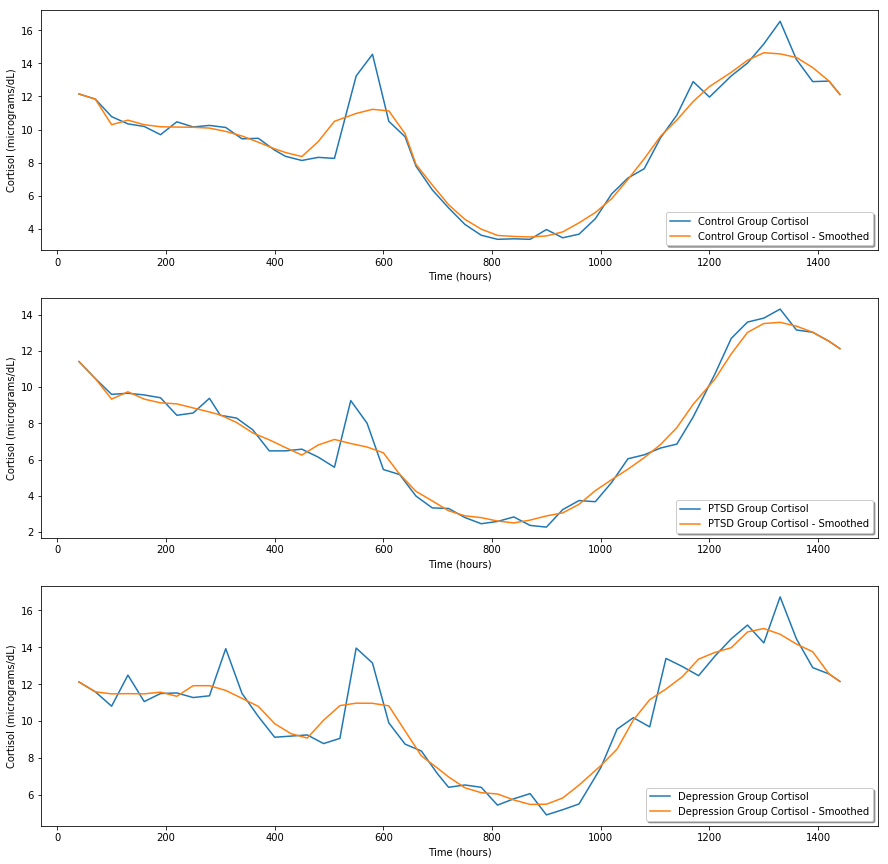

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

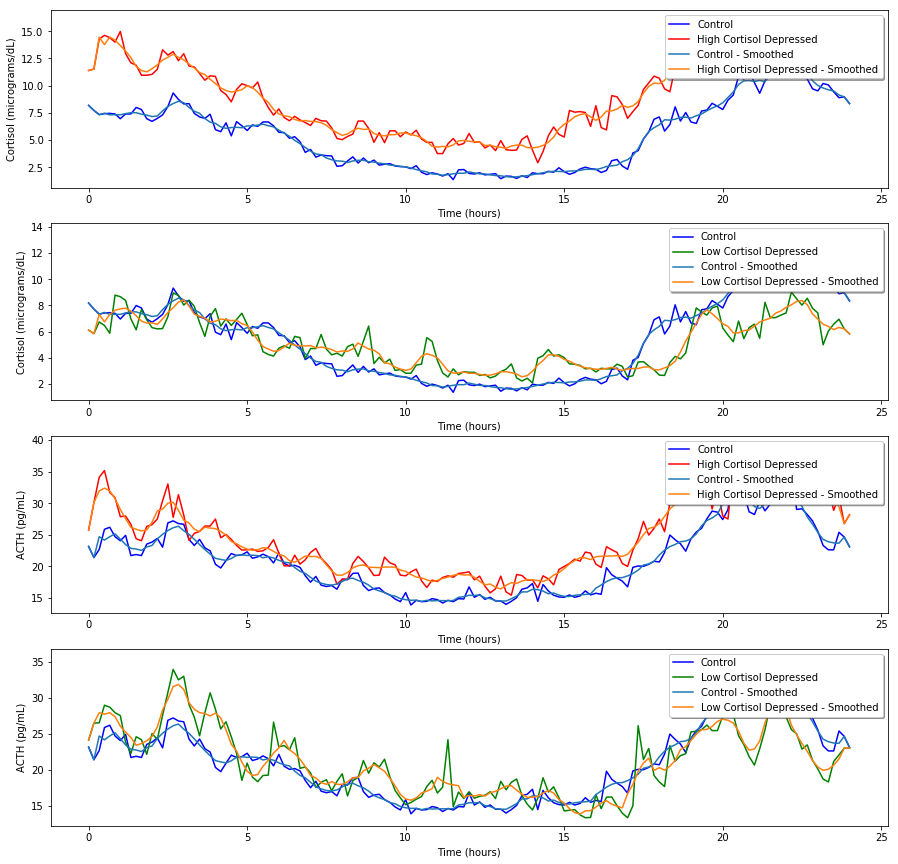

In [36]:
#mpld3.enable_notebook()
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

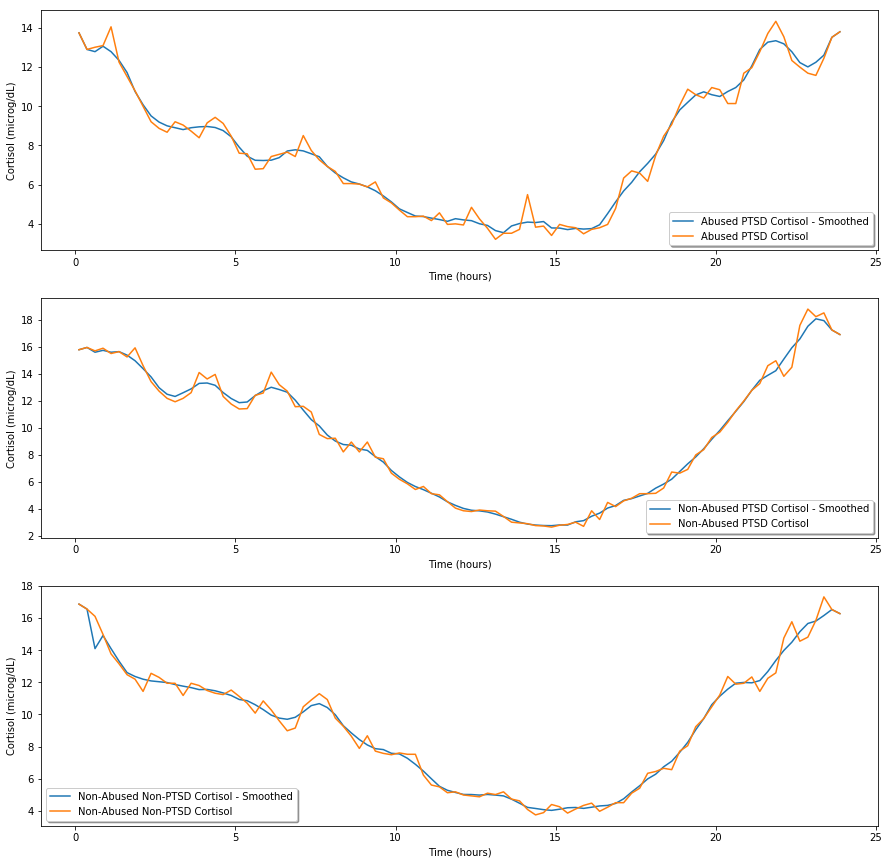

In [37]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)

In [62]:
# arrange and graph the Nelson data
nelsonACTH_mean = np.zeros(11)
nelsonCortisol_mean = np.zeros(11)
nelsonACTH = np.zeros((11,60))
nelsonCortisol = np.zeros((11,60))


for i in range(len(nelsonACTH_data[1,:])-1):
    nelsonACTH_mean[i] = np.mean(nelsonACTH_data[:,i+1])
    nelsonCortisol_mean[i] = np.mean(nelsonCortisol_data[:,i+1])

t_nelson = np.array([0, 15, 30, 40, 50, 65, 80, 95, 110, 125, 140])
#t_nelson = t_nelson/60

for i in range(len(t_nelson)):
    nelsonACTH[i,0] = t_nelson[i]
    nelsonACTH[i,1] = nelsonACTH_mean[i]

    nelsonCortisol[i,0] = t_nelson[i]
    nelsonCortisol[i,1] = nelsonCortisol_mean[i]

for i in range(len(nelsonACTH_data)):
    for j in range(len(t_nelson)):
        nelsonACTH[j,i+2] = nelsonACTH_data[i,j+1]
        nelsonCortisol[j,i+2] = nelsonCortisol_data[i,j+1]



IndexError: index 60 is out of bounds for axis 1 with size 60

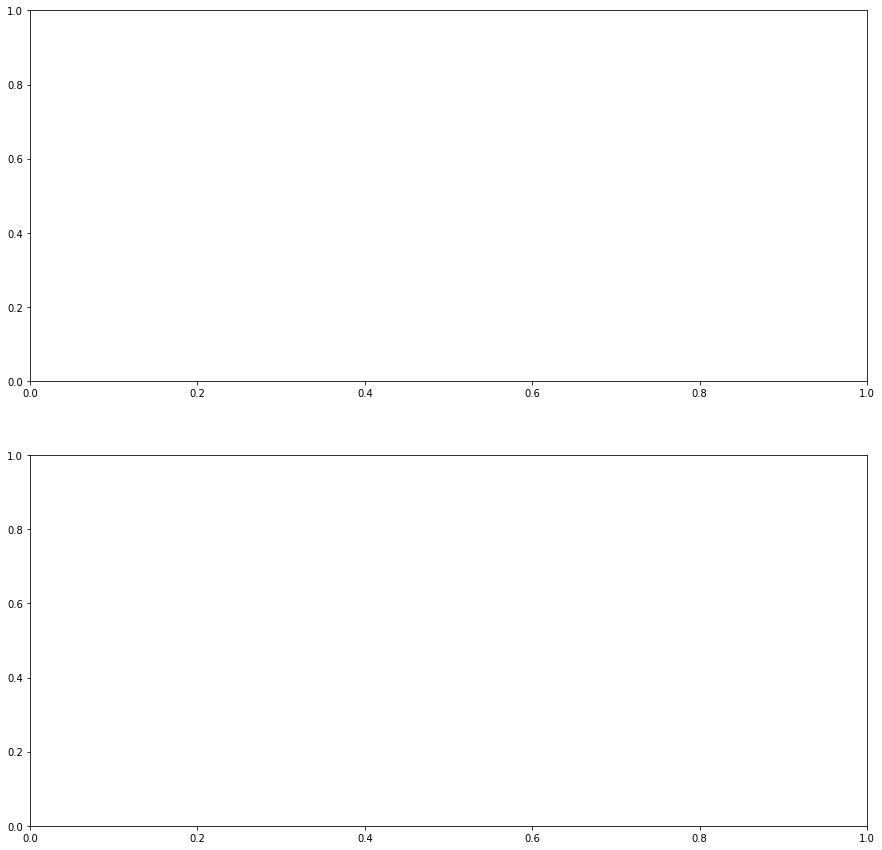

In [128]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,60], label = "Patient 59 ACTH")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "Nelson ACTH Data")
ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,60], label = "Patient 59 Cortisol")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Nelson Cortisol Data")

plt.savefig("nelsonData-patient59-dataOnly.png", dpi = 300)

## Model Function--Includes ODE Solver

In [131]:
def model(params, ics, t):
    def ode_system(t, y):
        dy = np.zeros(3)
        [eta, K_d, k_1, k_2, k_3, sigma, k_C0, tau, S_e, t_spike] = params

        # let's try adding an if/else statement to check the time and
        # delay the CRH spike until 30 minutes have passed
        #if (t <= t_spike):
        #    k_C = (k_1*y[0])/(1 - eta*(y[2]/(K_d + y[2])))
        #else:
            # not sure which of these definitions of S I should be using
            #S = S_e - sigma
        S = (S_e - sigma)*np.exp(-t/tau)
            # compute k_C, which determines how much CRH is being produced
            # at this time step, based on the level of stressor, S_e
        k_C = k_C0*np.exp(S - sigma)

        dy[0] = k_C*(1 - eta*(y[2]/(K_d + y[2]))) - k_1*y[0]
        dy[1] = k_1*y[0] - k_2*y[1]
        dy[2] = k_2*y[1] - k_3*y[2]

        return dy

    # solve the system with scipy.integrate.ode to see if it's any faster
    solver = sci.ode(ode_system)
    solver.set_integrator('vode', method='bdf', atol=3e-14, rtol=1e-14, nsteps = 100000)
    solver.set_initial_value(ics, t_start)

    ts = []
    ys = []

    while solver.successful() and solver.t < t_end:
        solver.integrate(solver.t + t_step)
        ts.append(solver.t)
        ys.append(solver.y)

    # reshape the output frome ode to an array with the times on the first column
    ts = np.reshape(ts, (len(ts),1))
    ys = np.vstack(ys)
    timeSeries = np.hstack((ts, ys))
    return timeSeries

## Cost Function Definition

In [132]:
def cost_fun(params):
    # call the solve function
    simData = model(params, y0, timeLength)

    # this is where Rick makes sure we only have unique values for t, so no time step is repeated
    # I'll include it commented out here, and see if it changes anything later
    #idx = np.unique(simData[:,0], return_index = True)
    #idx = idx[1]\n",
    #simData = simData[idx,:]

    # here, rick performs a cubic interpolation between time steps
    # I could either do this, or just compute the SSE between the raw data and computed data points without doing
    # the interpolation (as long as every raw data point is hit by the time steps the model computes)
    spline_ACTH = interp1d(simData[:,0], simData[:,2], kind = 'linear')
    spline_CORT = interp1d(simData[:,0], simData[:,3], kind = 'linear')

    try:
        # compute the actual cost value for the current parameter set by finding SSE between raw data and splines
        # this is where we change the data set we are trying to match, so that it computes the cost based on whatever
        #     data set we put in as the x values into the spline and the y values to subtract
        acthSSE = np.sum((spline_ACTH(nelsonACTH[:,0]) - nelsonACTH[:,25])**2)
        cortSSE = np.sum((spline_CORT(nelsonCortisol[:,0]) - nelsonCortisol[:,25])**2)

        # if i run it with acth data, also, can make cost the average of cortisol and ACTH SSEs
        cost = (acthSSE+cortSSE)/2
        # for now though, cost is just the SSE of cortisol data and simulation
        #cost = cortSSE

        return cost
    except ValueError:
        print("ODE solver did not make through all data points.")

## Run the Optimization

In [133]:
# number of times to run the optimization
n = 1

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
sims_cort = np.zeros((14002, n))
sims_acth = np.zeros((14002, n))
sims_crh = np.zeros((14002, n))

In [134]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, maxiter = 999, disp = True, popsize = 1)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0, timeLength)
    # save CRH, cortisol and ACTH data into sims arrays
    sims_cort[:,i] = optimizedSimData[:,3]
    sims_acth[:,i] = optimizedSimData[:,2]
    sims_crh[:,i] = optimizedSimData[:,1]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1
differential_evolution step 1: f(x)= 636.957
differential_evolution step 2: f(x)= 636.957
differential_evolution step 3: f(x)= 636.957
differential_evolution step 4: f(x)= 628.779
differential_evolution step 5: f(x)= 628.779
differential_evolution step 6: f(x)= 605.356
differential_evolution step 7: f(x)= 605.356
differential_evolution step 8: f(x)= 605.317
differential_evolution step 9: f(x)= 603.15
differential_evolution step 10: f(x)= 586.29
differential_evolution step 11: f(x)= 572.17
differential_evolution step 12: f(x)= 572.17
differential_evolution step 13: f(x)= 569.097
differential_evolution step 14: f(x)= 555.245
differential_evolution step 15: f(x)= 554.776
differential_evolution step 16: f(x)= 544.04
differential_evolution step 17: f(x)= 544.04
differential_evolution step 18: f(x)= 543.291
differential_evolution step 19: f(x)= 541.388
differential_evolution step 20: f(x)= 540.626
CPU times: user 1min 42s, sys: 2.14 s, total: 1min 44s
Wall time: 1min 44s


## Save Output to File

In [135]:
np.savetxt('savicModel-nelson-opt-pars-patient24-1-iteration.txt', opt_pars)

In [136]:
np.savetxt('savicModel-nelson-sims-crh-patient24-1-iteration.txt', sims_crh)
np.savetxt('savicModel-nelson-sims-acth-patient24-1-iteration.txt', sims_acth)
np.savetxt('savicModel-nelson-sims-cort-patient24-1-iteration.txt', sims_cort)

In [137]:
np.savetxt('savicModel-nelson-initial-conditions-patient24-1-iteration.txt', y0)
np.savetxt('savicModel-nelson-bounds-patient24-1-iteration-with.txt', bounds)

## Compute Means and Std Devations of Parameters and Output as Table

In [138]:
eta_mean = np.mean(opt_pars[:,1])
eta_std = np.std(opt_pars[:,1])
K_d_mean = np.mean(opt_pars[:,2])
K_d_std = np.std(opt_pars[:,2])
k_1_mean = np.mean(opt_pars[:,3])
k_1_std = np.std(opt_pars[:,3])
k_2_mean = np.mean(opt_pars[:,4])
k_2_std = np.std(opt_pars[:,4])
k_3_mean = np.mean(opt_pars[:,5])
k_3_std = np.std(opt_pars[:,5])
sigma_mean = np.mean(opt_pars[:,6])
sigma_std = np.std(opt_pars[:,6])
k_C0_mean = np.mean(opt_pars[:,7])
k_C0_std = np.std(opt_pars[:,7])
tau_mean = np.mean(opt_pars[:,8])
tau_std = np.std(opt_pars[:,8])
S_e_mean = np.mean(opt_pars[:,9])
S_e_std = np.std(opt_pars[:,9])

In [139]:
print(tabulate([["eta", "%f +- %f" % (eta_mean, eta_std)], ["K_d", "%f +- %f" % (K_d_mean, K_d_std)], ["k_1", "%f +- %f" % (k_1_mean, k_1_std)], ["k_2", "%f +- %f" % (k_2_mean, k_2_std)], ["k_3", "%f +- %f" % (k_3_mean, k_3_std)], ["sigma", "%f +- %f" % (sigma_mean, sigma_std)], ["k_C0", "%f +- %f" % (k_C0_mean, k_C0_std)], ["tau", "%f +- %f" % (tau_mean, tau_std)], ["S_e", "%f +- %f" % (S_e_mean, S_e_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))

Parameter    Mean +- Standard Deviation
-----------  ----------------------------
eta          1.000000 +- 0.000000
K_d          4.955724 +- 0.000000
k_1          0.031148 +- 0.000000
k_2          0.009758 +- 0.000000
k_3          0.019000 +- 0.000000
sigma        2.646958 +- 0.000000
k_C0         0.365167 +- 0.000000
tau          9.500226 +- 0.000000
S_e          9.998701 +- 0.000000


In [141]:
np.savetxt('savicModel-nelson-patient24-param-means-stds-1-iteration.txt', [eta_mean, eta_std, K_d_mean, K_d_std, k_1_mean, k_1_std, k_2_mean, k_2_std, k_3_mean, k_3_std, sigma_mean, sigma_std, k_C0_mean, k_C0_std, tau_mean, tau_std, S_e_mean, S_e_std])

## Plots

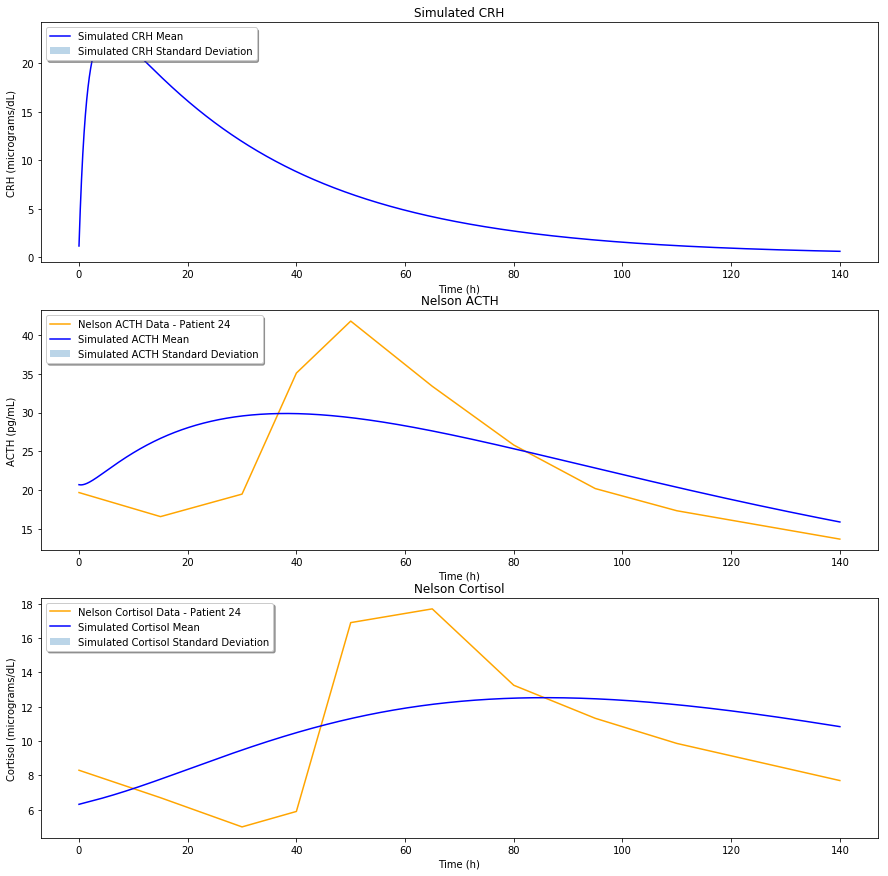

In [142]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15, 15))

ax1.plot(optimizedSimData[:,0], np.mean(sims_crh, axis = 1), label = "Simulated CRH Mean", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.3, label = "Simulated CRH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "CRH (micrograms/dL)", title = "Simulated CRH")

ax2.plot(nelsonACTH[:,0], nelsonACTH[:,25], label = "Nelson ACTH Data - Patient 24", color = "orange")
ax2.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Simulated ACTH Mean", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "Nelson ACTH")

ax3.plot(nelsonCortisol[:,0], nelsonCortisol[:,25], label = "Nelson Cortisol Data - Patient 24", color = "orange")
ax3.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Simulated Cortisol Mean", color = "blue")
ax3.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax3.legend(loc = "upper left", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Nelson Cortisol")

plt.savefig("savicModel-nelson-patient24-1-iteration.png", dpi = 300)